In [23]:
from scipy.interpolate import BSpline, interp1d
from scipy.integrate import trapz
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
import uproot
import ROOT
from ROOT import RooDecay, RooRealVar, RooGaussModel, RooArgList
import pandas as pd

In [4]:
ROOT.gSystem.Load('build/LibRooCubicSpline.so')

0

In [5]:
from ROOT import RooCubicSplineFun

In [6]:
%matplotlib inline

In [180]:
df = (
    uproot.open('/Users/kheinicke/playground/sWeights_Bs2DsPi_momscale_Minuit_20152016_Final.root')['data_sweight']
    .pandas.df(['BeautyTime', 'nSig*'], namedecode='utf8')
)

In [181]:
df = df.append(uproot.open('/Users/kheinicke/playground/sWeights_Bs2DsPi_momscale_Minuit_2017_Final.root')['data_sweight']
               .pandas.df(['BeautyTime', 'nSig*'], namedecode='utf8'))

In [182]:
df = df.append(uproot.open('/Users/kheinicke/playground/sWeights_Bs2DsPi_momscale_Minuit_2018_Final.root')['data_sweight']
               .pandas.df(['BeautyTime', 'nSig*'], namedecode='utf8'))

In [183]:
df['sw'] = df[[c for c in df.columns if c.startswith('nSig')]].sum(axis=1)

In [185]:
df['year'] = 0

In [193]:
df.loc[0, ['year']]

,year
entry,
0,0
0,1
0,2


In [195]:
df.loc[df[[c for c in df.columns if c.startswith('nSig') and 'run2' in c]].sum(axis=1) != 0, ['year']] = 0
df.loc[df[[c for c in df.columns if c.startswith('nSig') and '2017' in c]].sum(axis=1) != 0, ['year']] = 1
df.loc[df[[c for c in df.columns if c.startswith('nSig') and '2018' in c]].sum(axis=1) != 0, ['year']] = 2

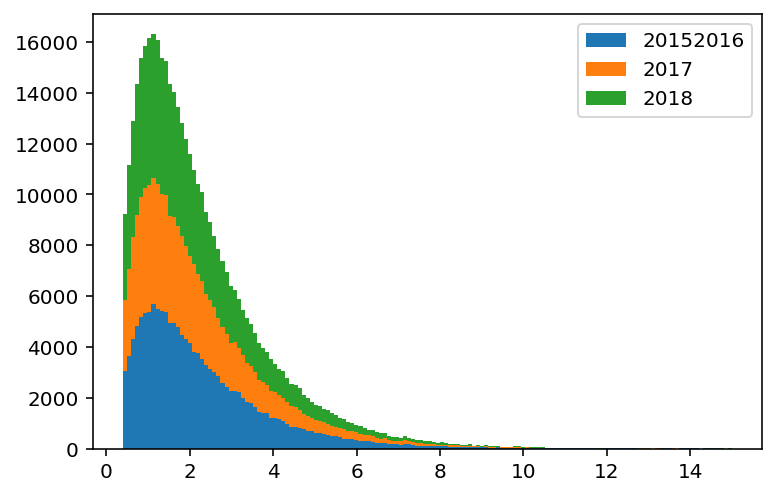

In [202]:
plt.figure(dpi=144)
times = [df[df.year == i].BeautyTime for i in range(3)]
weights = [df[df.year == i].sw for i in range(3)]
plt.hist(times, weights=weights, bins=150, histtype='barstacked', label=['20152016', '2017', '2018'])
plt.legend(loc='best')
plt.show()

In [10]:
timerange = (0.4, 15)

In [11]:
rwidth = RooRealVar('rwidth', 'rwidth', 0.045)
rmean = RooRealVar('rmean', 'rmean', 0)
time = RooRealVar('time', 'time', *timerange)
tau = RooRealVar('tau', 'tau', 1 / 0.663)

In [12]:
resolution = RooGaussModel('resolution', 'resolution', time, rmean, rwidth)
timepdf = RooDecay('timepdf', 'timepdf', time, tau, resolution, RooDecay.SingleSided)

In [13]:
xs = np.linspace(0.4, 15, 300)

In [14]:
def pdf(xs):
    global timepdf
    global time
    timeys = []
    for x in xs:
        time.setVal(x)
        timeys.append(timepdf.getVal())
    return np.array(timeys)

In [15]:
timeys = pdf(xs)

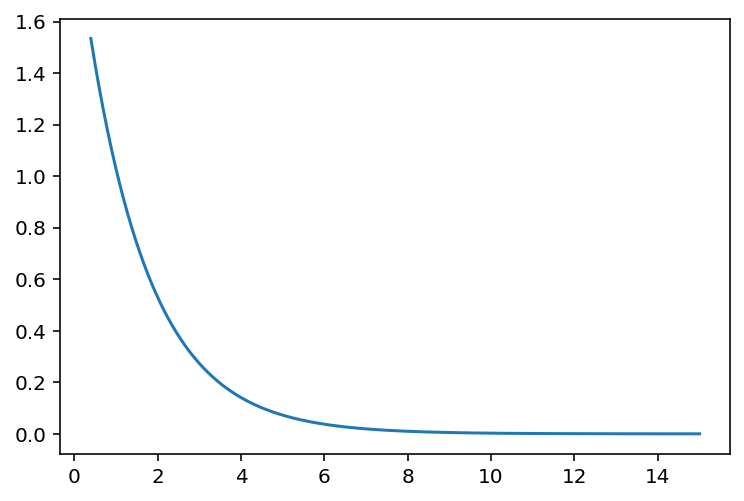

In [16]:
plt.figure(dpi=144)
plt.plot(xs, timeys)

In [17]:
t = 3 * [timerange[0]] + [0.5, 1, 2, 3, 12] + 3 * [timerange[1]]
c = [0.34, 0.52, 0.9, 1.05, 1.2, 1.0, 0.92]
k = 3

In [18]:
spl = BSpline(t, c, k)

In [19]:
spl.basis_element(t[:4])

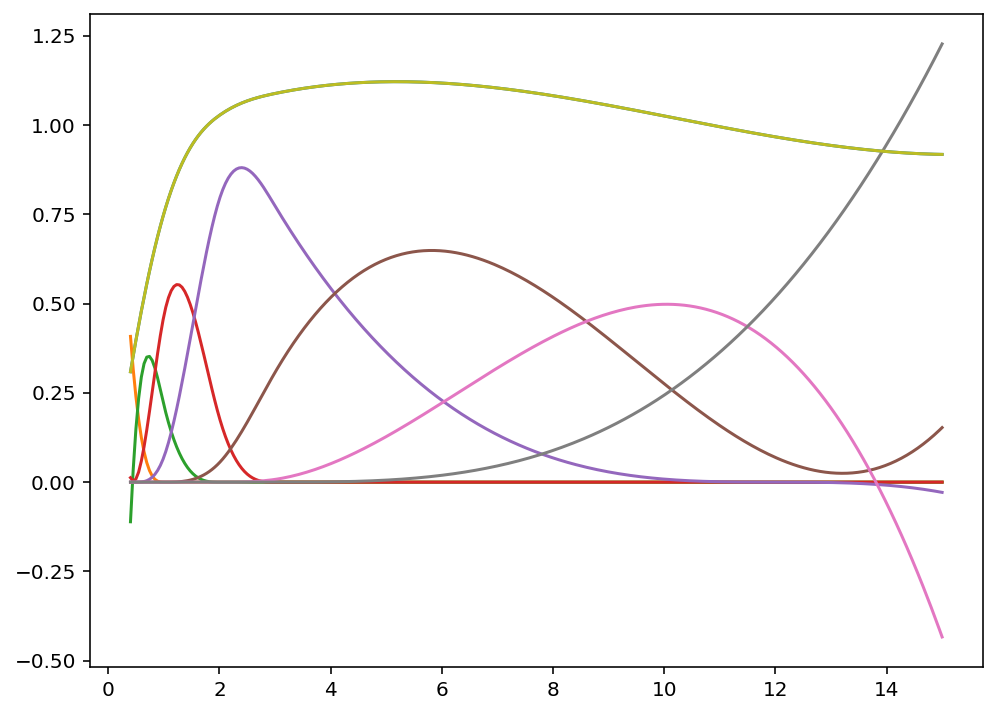

In [20]:
plt.figure(figsize=(8, 6), dpi=144)
plt.plot(xs, spl(xs))
spl_sum = []
for i in range(len(c)):
    subc = np.zeros_like(c)
    subc[i] = c[i]
    subspl = BSpline(t, subc, k)
    plt.plot(xs, subspl(xs))
    spl_sum.append(subspl(xs))
plt.plot(xs, np.sum(spl_sum, axis=0))

In [21]:
class Foo():
    def __call__(self):
        print('called')

In [71]:
def splineGen(t, c, k=3, impl='scipy'):
    if impl == 'scipy':
        return BSpline(t, c, k)
    elif impl == 'root':
        class RooSpline():
            def __init__(self, t, c, *args):
                self.x = RooRealVar('x', 'x', 0)
                self.rooCoeffList = [
                    RooRealVar(f'c{i}', f'c{i}', cv) for i, cv in enumerate(c)
                ]
                self.t = ROOT.std.vector('double')()
                for tv in t[3:-3]:
                    self.t.push_back(tv)
                self.coeffs = RooArgList()
                for c in self.rooCoeffList:
                    self.coeffs.add(c)
                if self.t.size() + 2 == self.coeffs.getSize():
                    self.spline = RooCubicSplineFun('spline', 'spline', self.x, self.t, self.coeffs)
                else:
                    raise ValueError('Inconsistent knots and splines for cubic BSpline')
                
            def __call__(self, xs):
                ys = []
                if type(xs) not in [np.array, np.ndarray, list]:
                    xs = [xs]
                for x in xs:
                    self.x.setVal(x)
                    ys.append(self.spline.getVal())
                return np.array(ys)
                
        return RooSpline(t, c)

In [72]:
type(xs) in [np.array, np.ndarray]

True

In [96]:
def splinomat(t, c, k=3, xmax=6, impl='scipy'):
    spl = splineGen(t, c, k, impl=impl)

    plt.figure(dpi=144)
    hist, bins, _ = plt.hist(df.BeautyTime, weights=df.sw, bins=150)
    binwidth = bins[1] - bins[0]
    scale = binwidth * hist.sum() / trapz(spl(xs) * timeys, xs)
    plt.plot(xs, spl(xs) * timeys * scale)
    plt.vlines(t, 0, plt.ylim()[1] * 0.9, linestyle='--', color='grey')
    for i in range(len(c)):
        subc = np.zeros_like(c)
        subc[i] = c[i]
        subspl = splineGen(t, subc, k, impl='root')
        ys = subspl(xs) * timeys * scale
        plt.plot(xs, ys)
        if xs[ys.argmax()] < xmax:
            plt.text(xs[ys.argmax()], ys.max(), str(c[i]), color=f'C{i+2}')
    plt.ylim(bottom=0)
    plt.xlim(0, xmax)
    ax1 = plt.gca()
    plt.gca().twinx()
    plt.plot(xs, spl(xs), 'C2--')
    ax2 = plt.gca()
    f = plt.gcf()
    return f, ax1, ax2

(1, 5289.827848470018)

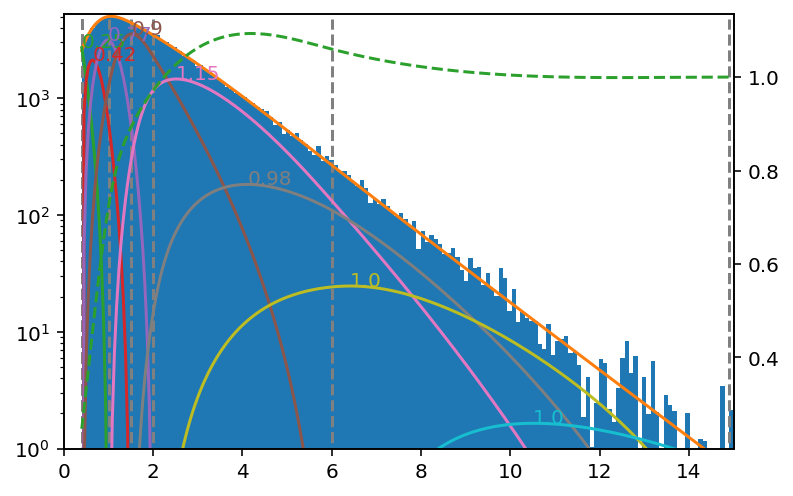

In [102]:
f, a1, a2 = splinomat(
    3 * [timerange[0]] + [0.41, 1., 1.5, 2., 6., 14.9] + 3 * [timerange[1]],
    [0.25, 0.42, 0.77, 0.9, 1.15, 0.98, 1.0, 1.0],
    xmax=15,
)
a1.set_yscale('log')
a1.set_ylim(bottom=1)

(1, 5847.366036467049)

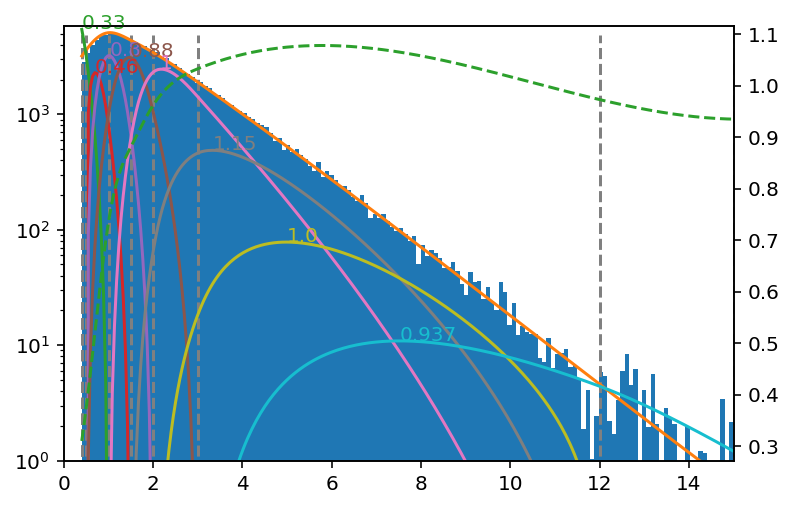

In [103]:
f, a1, a2 = splinomat(
    3 * [timerange[0]] + [0.5, 1., 1.5, 2., 3, 12] + 3 * [timerange[1]],
    [0.33, 0.46, 0.8, 0.88, 1, 1.15, 1.0, 0.937],
    xmax=15
)
a1.set_yscale('log')
a1.set_ylim(bottom=1)

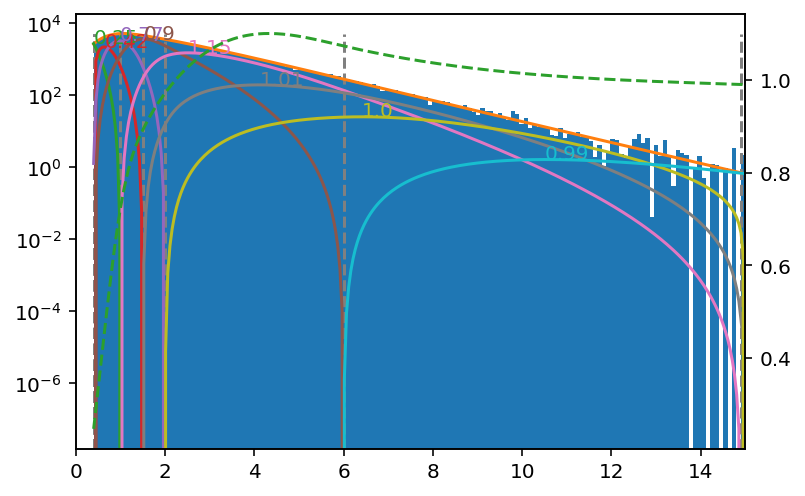

In [76]:
t = 3 * [timerange[0]] + [0.41, 1., 1.5, 2., 6., 14.9] + 3 * [timerange[1]]
c = [0.25, 0.42, 0.77, 0.9, 1.15, 1.01, 1.0, 0.99]
k = 3

spl = BSpline(t, c, k)

xmax = 15

plt.figure(dpi=144)
hist, bins, _ = plt.hist(df.BeautyTime, weights=df.sw, bins=150)
binwidth = bins[1] - bins[0]
scale = binwidth * hist.sum() / trapz(spl(xs) * timeys, xs)
plt.plot(xs, spl(xs) * timeys * scale)
plt.vlines(t, 0, plt.ylim()[1] * 0.9, linestyle='--', color='grey')
for i in range(len(c)):
    subc = np.zeros_like(c)
    subc[i] = c[i]
    subspl = BSpline(t, subc, k)
    ys = subspl(xs) * timeys * scale
    plt.plot(xs, ys)
    if xs[ys.argmax()] < xmax:
        plt.text(xs[ys.argmax()], ys.max(), str(c[i]), color=f'C{i+2}')
# plt.ylim(bottom=0)
plt.xlim(0, xmax)
plt.yscale('log')
plt.gca().twinx()
plt.plot(xs, spl(xs), 'C2--')


In [77]:
hist, bins = np.histogram(df.BeautyTime, bins=110)
low, high = poisson.interval(0.682, hist)
low / hist, high / hist
rolling_low = pd.DataFrame(low / hist).rolling(30).mean()
lowf = interp1d(bins[10:-1] + (bins[1] - bins[0]) / 2, rolling_low[0][10:])

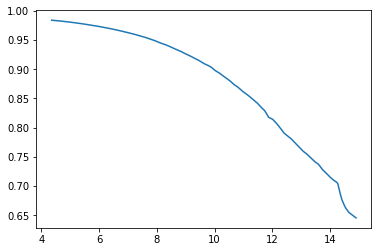

In [78]:
plt.plot(xs[(xs > lowf.x.min()) & (xs < lowf.x.max())], lowf(xs[(xs > lowf.x.min()) & (xs < lowf.x.max())]))

In [212]:
def filled(t=3 * [0.4] + [0.5, 1., 1.5, 2., 3, 12] + 3 * [15],
           mean_c=[0.25, 0.42, 0.77, 0.9, 1.15, 1.01],
           cov=None, lastknot=1, label='', normrange=(0, 6), mock_uncertainty_from=None,
           impl='scipy', **kwargs):
    if cov is None:
        cov = np.array(len(mean_c) * [len(mean_c) * [0.75 * 0.02]])
        np.fill_diagonal(cov, 0.02)

    cs = np.random.multivariate_normal(mean_c, cov, size=500)

    xs = np.linspace(0.4, 15, 300)

    cs[0:5]

    ys = [splineGen(t, np.append(c, [1, lastknot]), k, impl=impl)(xs) for c in cs]

    splys = splineGen(t, np.append(mean_c, [1, lastknot]), k, impl=impl)(xs)
    normmask = (xs > normrange[0]) & (xs < normrange[1])
    norm = trapz(splys[normmask], xs[normmask])
    plt.plot(xs, splys / norm, label=label, **kwargs)
    low, high = np.percentile(ys, [15.9, 84.1], axis=0)
    if mock_uncertainty_from is not None:
        hist, bins = np.histogram(mock_uncertainty_from, bins=110)
        low_mock, high_mock = poisson.interval(0.682, hist)
        rolling_low = pd.DataFrame(low_mock / hist).rolling(10).mean()
        lowf = interp1d(bins[10:-1] + (bins[1] - bins[0]) / 2, rolling_low[0][10:])
        func_diff = splys - low
        # print(func_diff)
        # low -= splys - np.sqrt((splys - low_mock) ** 2 + ((1 - lowf(xs)) * splys) ** 2)
    plt.fill_between(xs, low / norm, high / norm, alpha=0.2, **kwargs)

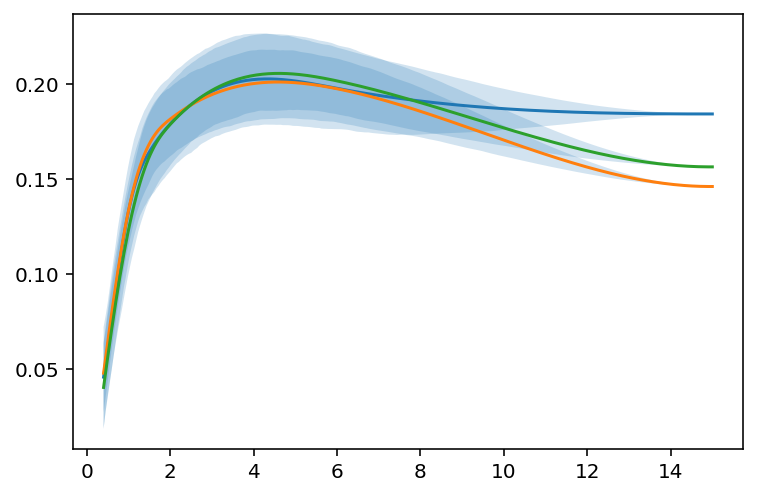

In [170]:
plt.figure(dpi=144)
t = 3 * [timerange[0]] + [0.41, 1., 1.5, 2., 6., 14.9] + 3 * [timerange[1]]
filled(t, mock_uncertainty_from=df.BeautyTime)
filled(t, mean_c=[0.33, 0.56, 0.95, 1.18, 1.40, 1.38])
filled(t, mean_c=[0.26, 0.47, 0.81, 1.06, 1.35, 1.29])

In [82]:
def get_c_cov(fitresult, y='20152016'):
    cov = np.array(6 * [6 * [0.0]])
    for i in range(6):
        for j in range(6):
            if i == j:
                cov[i, j] = fitresult.floatParsFinal().find(f'var{i + 1}_{y}').getError() ** 2
            else:
                cov[i, j] = cov[j, i] = (
                    fitresult.correlation(f'var{i + 1}_{y}', f'var{j + 1}_{y}')
                    * fitresult.floatParsFinal().find(f'var{i + 1}_{y}').getError()
                    * fitresult.floatParsFinal().find(f'var{j + 1}_{y}').getError()
                )
    c = [fitresult.floatParsFinal().find(f'var{i}_{y}').getVal() for i in range(1, 7)]
    return c, cov

In [83]:
def get_coeff(max, t0, t1, c):
    c2 = 1 - (max - t1) / (t0 - t1)
    c1 = (max - t1) / (t0 - t1)
    return c1 * c[-2] + c2 * c[-1]

In [84]:
oldknotsrf = ROOT.TFile('/Users/kheinicke/playground/WS_sFit_noglm_all_fitresult.root')
oldknotsr = oldknotsrf.Get('fitresult')

In [85]:
normrange = np.percentile(df.BeautyTime, [2.5, 97.5])
normrange

array([0.4956243 , 6.33629684])

In [155]:
from matplotlib.colors import to_rgba

0.9074044598885643
0.9488053283940483
0.9086740039097265


(0.4, 15)

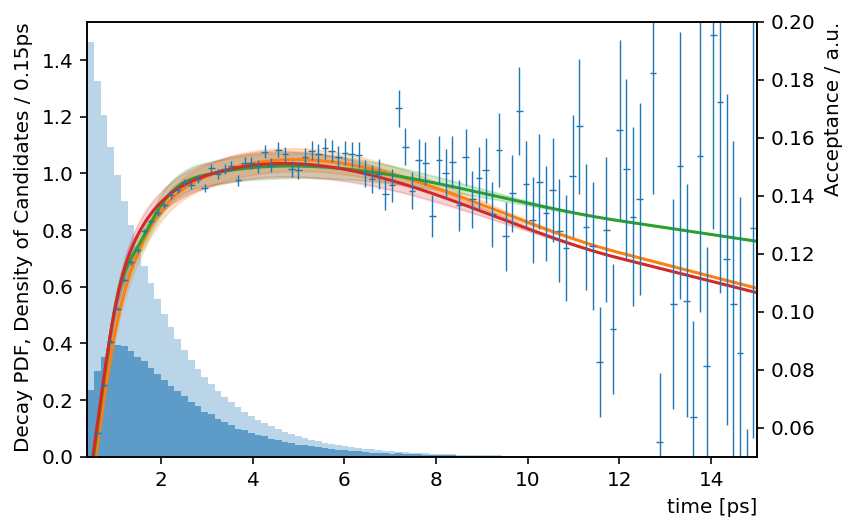

In [217]:
plt.figure(dpi=144)
timeys = []
hist, bins = np.histogram(df.BeautyTime, bins=100, weights=df.sw, density=True)
absolute_hist, _ = np.histogram(df.BeautyTime, bins=bins, weights=df.sw)
binwidth = bins[1] - bins[0]
bincenters = bins[0:-1] + binwidth / 2
for x in bincenters:
    time.setVal(x)
    timeys.append(timepdf.getVal())
timeys = np.array(timeys)
plt.bar(bincenters, timeys, binwidth, color=to_rgba('C0', 0.3))
plt.bar(bincenters, hist, binwidth, color=to_rgba('C0', 0.6))
plt.ylabel(f'Decay PDF, Density of Candidates / {binwidth:.2g}ps', ha='right', y=1)
plt.xlabel('time [ps]', ha='right', x=1)
plt.ylim(bottom=0)

plt.gca().twinx()
normrange = (bincenters > 1) & (bincenters < 8)
scale = trapz((hist / timeys)[normrange], bincenters[normrange])
yerr_rel = np.sqrt(absolute_hist) / absolute_hist
plt.errorbar(
    bincenters,
    hist / timeys / scale, xerr=binwidth / 2,
    yerr=yerr_rel * hist / timeys / scale,
    fmt=',',
    zorder=1,
    linewidth=0.7)

t = 3 * [0.4] + [0.5, 1., 1.5, 2., 3, 12] + 3 * [15]

for i, y in enumerate(['20152016', '2017', '2018']):
    c, cov = get_c_cov(oldknotsr, y=y)
    lastknot = get_coeff(15, t[-5], t[-4], c + [1])
    print(lastknot)
    filled(t=t, mean_c=c, cov=cov, lastknot=lastknot, label=y, normrange=(1, 8), impl='root',
           color=f'C{i + 1}', zorder=0)
plt.ylim(0.05, 0.2)
plt.ylabel('Acceptance / a.u.', ha='right', y=1)
plt.xlim(0.4, 15)

In [146]:
hist

array([ 2.36753547e-01,  3.08049040e-01,  3.55274693e-01,  3.91754512e-01,
        4.02765572e-01,  3.93189494e-01,  3.70153681e-01,  3.48828107e-01,
        3.31785369e-01,  3.12091932e-01,  2.89497462e-01,  2.75384121e-01,
        2.47900237e-01,  2.29781874e-01,  2.14096852e-01,  1.89030687e-01,
        1.75978239e-01,  1.55666023e-01,  1.48626169e-01,  1.36339085e-01,
        1.20684774e-01,  1.12699431e-01,  9.67957764e-02,  9.24557624e-02,
        8.53662272e-02,  7.74017763e-02,  7.17206549e-02,  6.43590354e-02,
        5.91067367e-02,  5.01689840e-02,  4.58861604e-02,  4.22545187e-02,
        3.83344319e-02,  3.70503556e-02,  3.03900478e-02,  2.76379327e-02,
        2.87759574e-02,  2.45280201e-02,  2.31613556e-02,  1.97536676e-02,
        1.88725463e-02,  1.56718301e-02,  1.49275690e-02,  1.43423785e-02,
        1.07232152e-02,  1.00752795e-02,  1.12098047e-02,  8.19415776e-03,
        8.46949995e-03,  7.19864542e-03,  6.47477985e-03,  5.24021784e-03,
        5.57388947e-03,  

0.9074044598885643
0.9488053283940483
0.9086740039097265


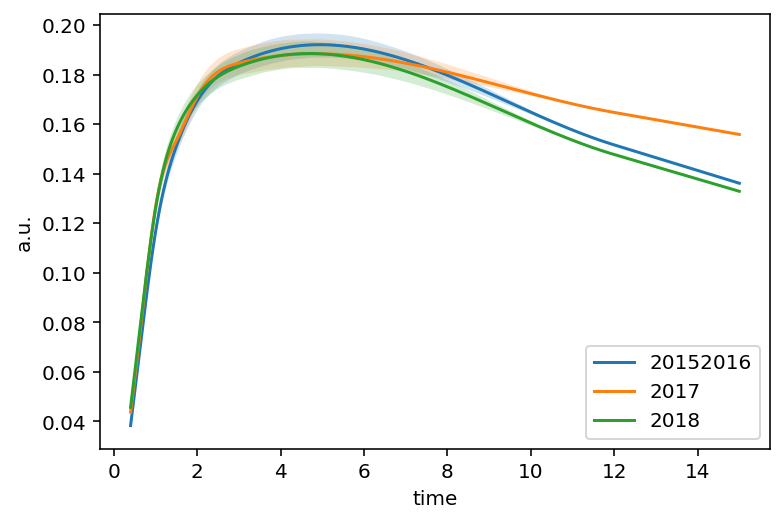

In [119]:
plt.figure(dpi=144)

t = 3 * [0.4] + [0.5, 1., 1.5, 2., 3, 12] + 3 * [15]

c, cov = get_c_cov(oldknotsr)
lastknot = get_coeff(15, t[-5], t[-4], c + [1])
print(lastknot)
filled(t=t, mean_c=c, cov=cov, lastknot=lastknot, label='20152016', normrange=normrange, impl='root')

c, cov = get_c_cov(oldknotsr, y='2017')
lastknot = get_coeff(15, t[-5], t[-4], c + [1])
print(lastknot)
filled(t=t, mean_c=c, cov=cov, lastknot=lastknot, label='2017', normrange=normrange, impl='root')

c, cov = get_c_cov(oldknotsr, y='2018')
lastknot = get_coeff(15, t[-5], t[-4], c + [1])
print(lastknot)
filled(t=t, mean_c=c, cov=cov, lastknot=lastknot, label='2018', normrange=normrange, impl='root')

# plt.xlim(left=0.5)
# plt.ylim(bottom=0.05)
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('a.u.')
# plt.yscale('log')

# plt.gca().twinx()
# plt.hist(df.BeautyTime, weights=df.sw, bins=100, color='C1', histtype='step')
# plt.ylabel('Candidates')
# plt.yscale('log')
plt.show()

0.9074044598885643


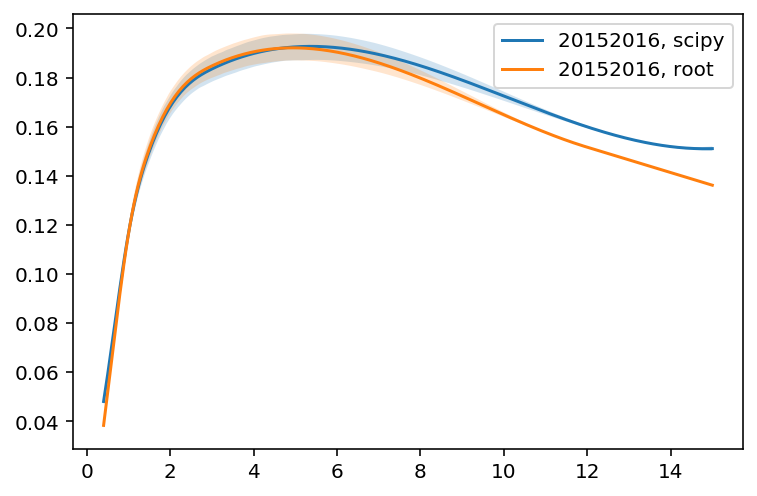

In [112]:
plt.figure(dpi=144)

t = 3 * [0.4] + [0.5, 1., 1.5, 2., 3, 12] + 3 * [15]

c, cov = get_c_cov(oldknotsr)
lastknot = get_coeff(15, t[-5], t[-4], c + [1])
print(lastknot)
filled(t=t, mean_c=c, cov=cov, lastknot=lastknot, label='20152016, scipy', normrange=normrange)
filled(t=t, mean_c=c, cov=cov, lastknot=lastknot, label='20152016, root', normrange=normrange, impl='root')
plt.legend(loc='best')

In [89]:
newknotsrf = ROOT.TFile('/Users/kheinicke/playground/WS_sFit_noglm_newknots_all_fitresult.root')
newknotsr = newknotsrf.Get('fitresult')

(0.05, 0.21614683266480045)

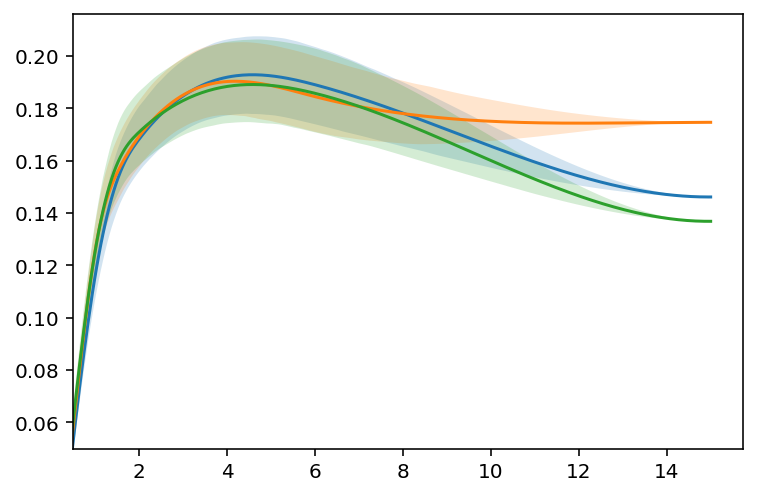

In [114]:
plt.figure(dpi=144)

t = 3 * [timerange[0]] + [0.41, 1., 1.5, 2., 6., 14.9] + 3 * [timerange[1]]

c, cov = get_c_cov(newknotsr)
filled(t=t, mean_c=c, cov=cov, lastknot=1, normrange=normrange)

c, cov = get_c_cov(newknotsr, y='2017')
filled(t=t, mean_c=c, cov=cov, lastknot=1, normrange=normrange)

c, cov = get_c_cov(newknotsr, y='2018')
filled(t=t, mean_c=c, cov=cov, lastknot=1, normrange=normrange)

plt.xlim(left=0.5)
plt.ylim(bottom=0.05)

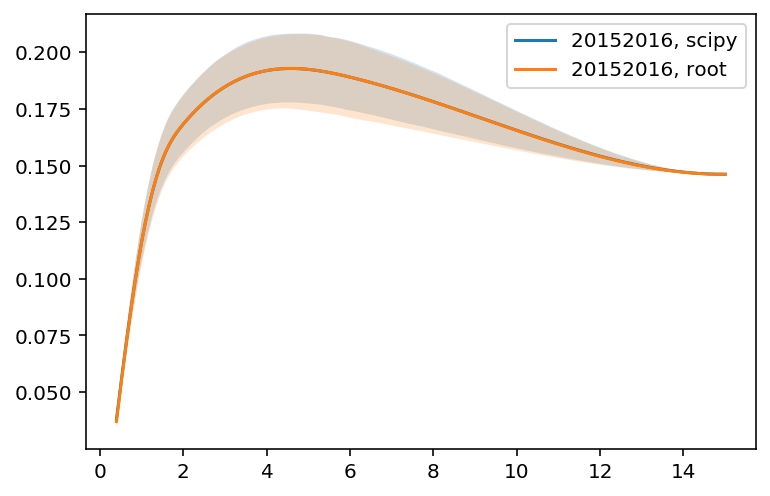

In [117]:
plt.figure(dpi=144)
c, cov = get_c_cov(newknotsr)
filled(t=t, mean_c=c, cov=cov, lastknot=1, normrange=normrange, label='20152016, scipy')
filled(t=t, mean_c=c, cov=cov, lastknot=1, normrange=normrange, label='20152016, root', impl='root')
plt.legend(loc='best')